<a href="https://colab.research.google.com/github/KujalaDivya25/My-first-Project/blob/master/Trainer_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [11]:
DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [13]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)




In [ ]:
print(type(labels))

<class 'numpy.ndarray'>


In [16]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [18]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [20]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [21]:
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [23]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 59s 289ms/step - loss: 0.6010 - accuracy: 0.7204 - val_loss: 0.1774 - val_accuracy: 0.9766
Epoch 2/20
96/96 [==============================] - 27s 282ms/step - loss: 0.1955 - accuracy: 0.9551 - val_loss: 0.0915 - val_accuracy: 0.9818
Epoch 3/20
96/96 [==============================] - 27s 281ms/step - loss: 0.1173 - accuracy: 0.9703 - val_loss: 0.0654 - val_accuracy: 0.9870
Epoch 4/20
96/96 [==============================] - 27s 282ms/step - loss: 0.0785 - accuracy: 0.9823 - val_loss: 0.0509 - val_accuracy: 0.9896
Epoch 5/20
96/96 [==============================] - 27s 280ms/step - loss: 0.0756 - accuracy: 0.9762 - val_loss: 0.0448 - val_accuracy: 0.9870
Epoch 6/20
96/96 [==============================] - 27s 282ms/step - loss: 0.0587 - accuracy: 0.9868 - val_loss: 0.0395 - val_accuracy: 0.9870
Epoch 7/20
96/96 [==============================] - 27s 281ms/step - loss: 0.0515 - accuracy: 0.9877 - val_loss: 0.034

In [24]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [25]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
from sklearn.metrics import classification_report
from imutils import paths

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



In [26]:
model.save("/content/mask_detector.model", save_format="h5")

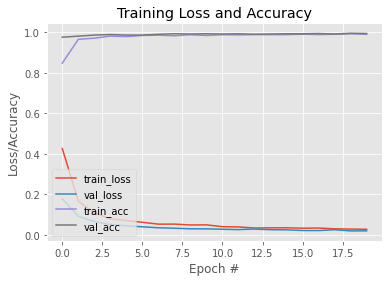

In [28]:
import matplotlib.pyplot as plt
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")